# Forecasting
Contents:
- Univariate time series forecasting
- Univariate time series forecasting with exogenous variables
- Multivariate time series forecasting


In [11]:
from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)

## Univariate forecasting: a basic workflow
In forecasting, we are interested in using past data to make temporal forward predictions. Sktime provides common statistical forecasting algorithms and tools for building composite machine learning models.

The **basic workflow** for forecasting is generating one single prediction for a single point in time
1. Specify the data
2. Specify the task (forecasting horizon)
3. Split the data
4. Specify the model
5. Fit
6. Predict
7. Evaluate

### 1. Specify the data


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

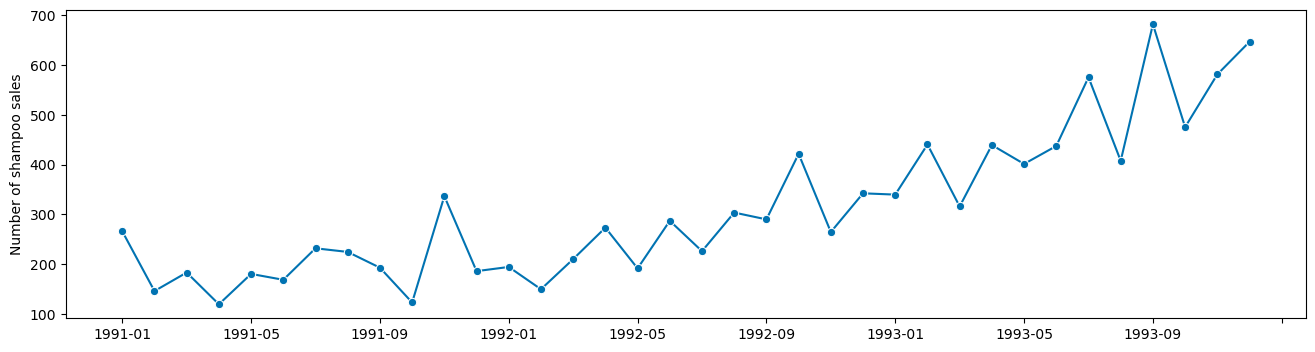

In [2]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

plot_series(y)

### 2. Task specification
Define a forecasting task; in the example:
- Try to predict the last 6 months of data, using the previous data as training data. Each point in the time series represents a month, so the last 6 points should be hold out as test data, and a 6-step ahead forecasting horizon should be used to evaluate the forecasting performance.
- The metric chosen to quantify the accuracy of the forecast is MAPE (mean absolute percentage error). A lower MAPE means higher accuracy.

#### Forecasting horizon
When forecasts are generated, a forecasting horizon has to be specified and passed as a parameter to the forecasting algorithm. The forecasting horizon can be specified as a numpy array of the steps ahead relative to the end of the training series:

- **Using an array of values**


In [3]:
import numpy as np

fh = np.arange(6) + 1
fh

array([1, 2, 3, 4, 5, 6])

- **Using the ForecastingHorizon object**

In [4]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(
    pd.period_range('1993-07', periods=6, freq='M'),
    is_relative=False
)
fh

ForecastingHorizon(['1993-07', '1993-08', '1993-09', '1993-10', '1993-11', '1993-12'], dtype='period[M]', is_relative=False)

In [5]:
cutoff = pd.Period('1993-06', freq='M')
fh.to_relative(cutoff)

ForecastingHorizon([1, 2, 3, 4, 5, 6], dtype='int64', is_relative=True)

### 3. Split the data
Split the data into train, test, and split datasets


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

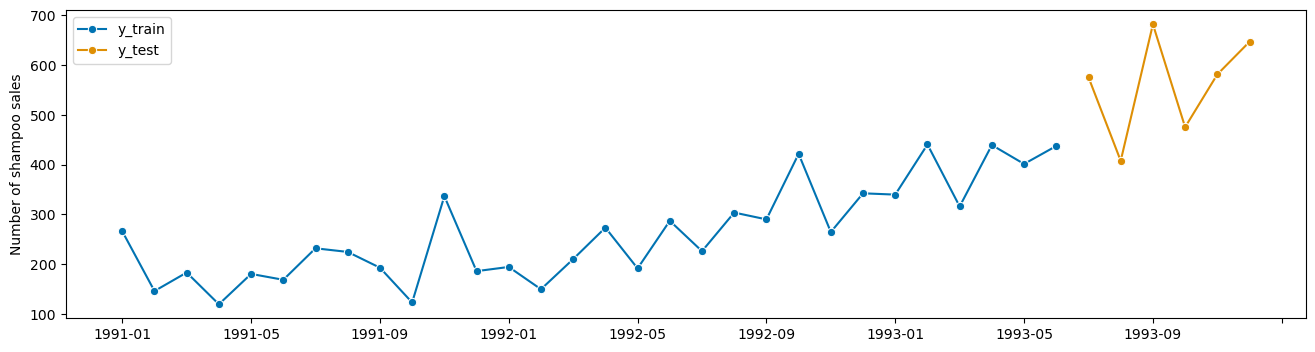

In [6]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, fh=fh)

plot_series(y_train, y_test, labels=['y_train', 'y_test'])

### 4. Model specification


In [7]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy='drift', window_length=10)

### 5. Fitting


In [8]:
forecaster.fit(y_train)

NaiveForecaster(strategy='drift', window_length=10)

Notice that the `fit` method is different from the one in sklearn


In [9]:
forecaster.fit?

Signature: forecaster.fit(y, X=None, fh=None)
Docstring:
Fit forecaster to training data.

State change:
    Changes state to "fitted".

Writes to self:
    Sets self._is_fitted flag to True.
    Writes self._y and self._X with `y` and `X`, respectively.
    Sets self.cutoff and self._cutoff to last index seen in `y`.
    Sets fitted model attributes ending in "_".
    Stores fh to self.fh if fh is passed.

Parameters
----------
y : time series in sktime compatible data container format
        Time series to which to fit the forecaster.
    y can be in one of the following formats:
    Series scitype: pd.Series, pd.DataFrame, or np.ndarray (1D or 2D)
        for vanilla forecasting, one time series
    Panel scitype: pd.DataFrame with 2-level row MultiIndex,
        3D np.ndarray, list of Series pd.DataFrame, or nested pd.DataFrame
        for global or panel forecasting
    Hierarchical scitype: pd.DataFrame with 3 or more level row MultiIndex
        for hierarchical forecasting
   

1. the first argument is the target series `y`
2. the second argument is exogenous data (see below)
3. the third argument is the forecasting horizon; it is not required for all models to pass the forecasting horizon in the fitting step 

### 6. Predicting


In [10]:
y_pred = forecaster.predict(fh)

### 7. Evaluating


In [11]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.16469764622516225

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

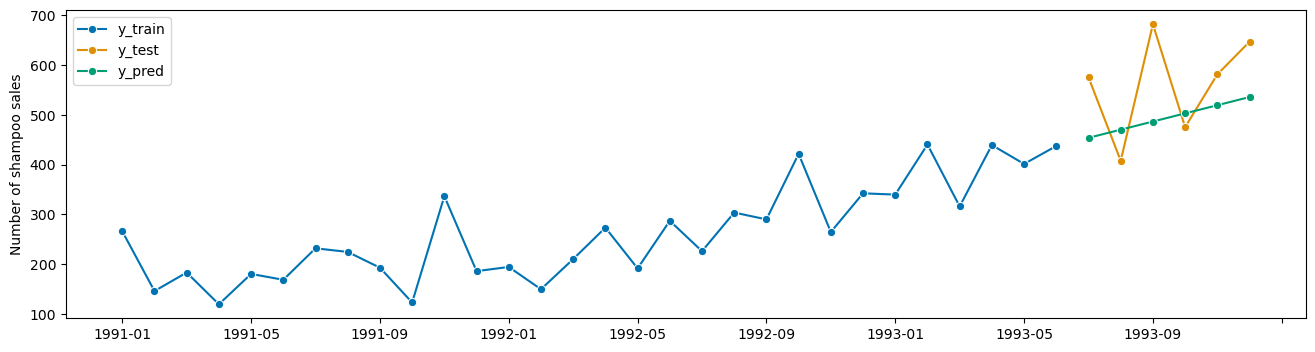

In [12]:
plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])

### Another example using the ARIMA model


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

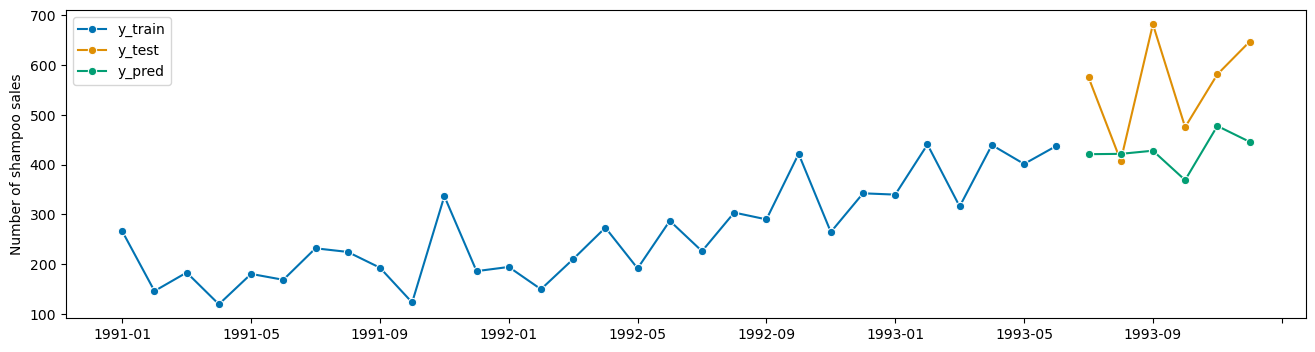

In [13]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import numpy as np

# data load
y = load_shampoo_sales()

# task specification: forecasting 6 months ahead
fh = np.arange(6) + 1

# split the data
y_train, y_test = temporal_train_test_split(y, fh=fh)

# model specification
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

# model fit
forecaster.fit(y_train)

# model predict
y_pred = forecaster.predict(fh)

# model evaluation
plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])

In [14]:
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.23140725522776395

### Summary of the basic workflow
- single, fixed cutoff point at which predictions are generated
- common interface for forecasters

### Forecasters in sktime
The complete list of sktime estimators is available [here](https://www.sktime.org/en/stable/estimator_overview.html)


In [15]:
from sktime.registry import all_estimators

# all_estimators('forecaster', as_dataframe=True)

### Is it possible to just use scikit-learn?
Using sklearn alone with time series data tasks has many pitfalls. It is better to use it together with sktime, since it provides a meta-estimator for this approach, that is:
- **modular** and **compatible with scikit-learn**, so that it is possible to easily apply any scikt-learn regressor to solve a forecasting problem
- **parametric** and **tuneable**, allowing to tune hyperparameters like the window length or the strategy to generate forecasts
- **adaptive**, in the sense that it adapts the scikit-learn estimator interface to that of a forecaster, making sure that the model can be properly tuned and evaluated


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

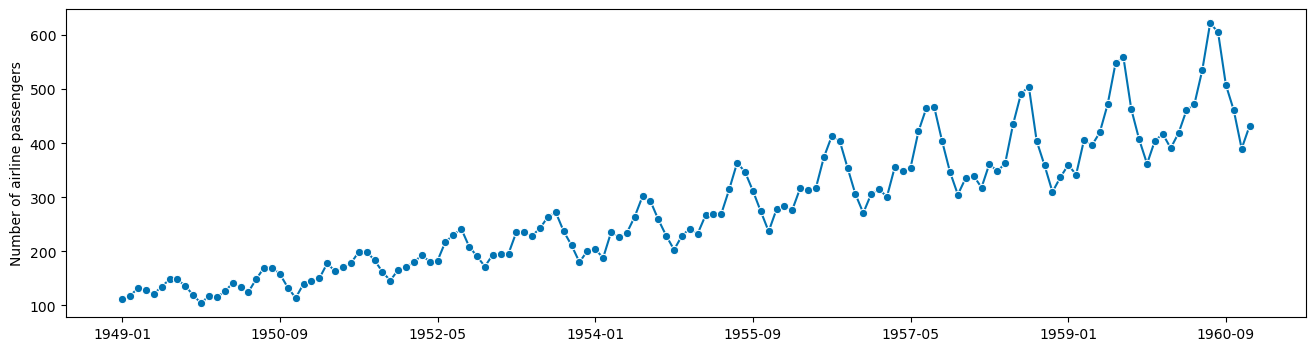

In [16]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

# data load
y = load_airline()
plot_series(y)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

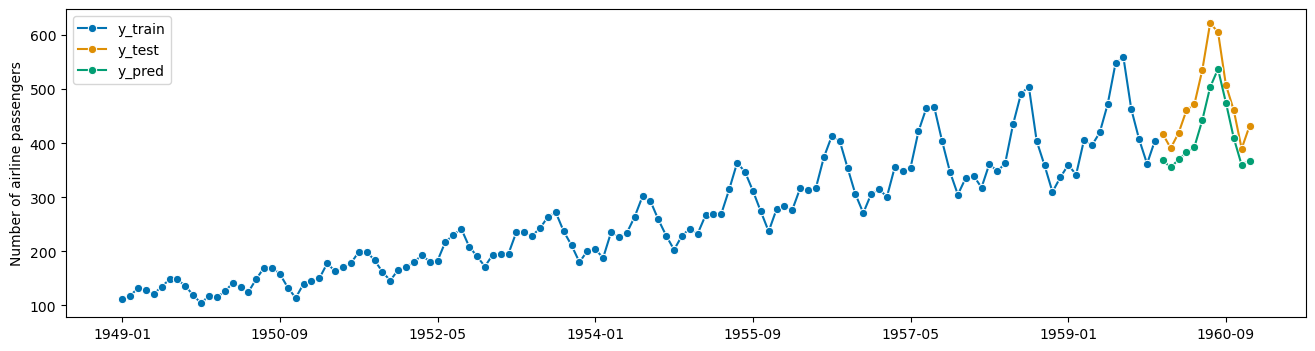

In [17]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

# model task and data split
y_train, y_test = temporal_train_test_split(y, test_size=12)
fh = ForecastingHorizon(y_test.index, is_relative=False)

# model specification
regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, strategy='recursive', window_length=12) 

# model fit
forecaster.fit(y_train, fh=fh)

# model predict
y_pred = forecaster.predict()

# model evaluation
plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])

In [18]:
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.12825559519541507

Notice that the function `make_reduction` wraps around a regressor and makes it possible to use it as a forecaster


## Univariate forcasting: a more advanced workflow
1. Specify the data
2. Specify the task
3. Split the data
4. Specify the model
5. Fit
6. Predict
7. Observe new data
8. Update using new data
9. Repeat steps 6 to 8 as often as required

### 1. Specify the data

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

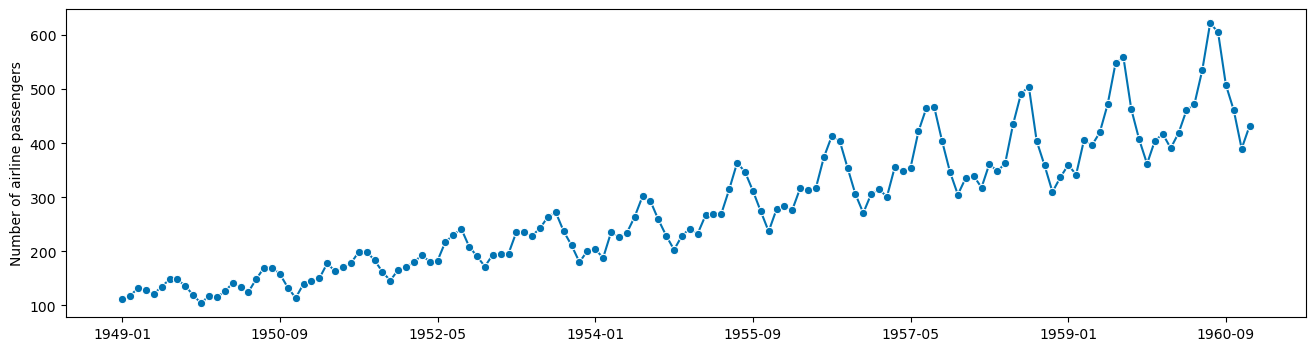

In [19]:
from sktime.datasets import load_airline

y = load_airline()
plot_series(y)

### 2. Task specification
The task is to predict one year ahead, one point per month

In [20]:
fh = np.arange(1,13)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### 3. Model split

In [21]:
y_train = y.loc[:'1957-08']
y_observed = y_train.copy() # these are the data that I consider received until now
y_observed.tail()

1957-04    348.0
1957-05    355.0
1957-06    422.0
1957-07    465.0
1957-08    467.0
Freq: M, Name: Number of airline passengers, dtype: float64

### 4. Model specification

In [22]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

### 5. Model fit

In [23]:
forecaster.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

### 6. Model predict

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

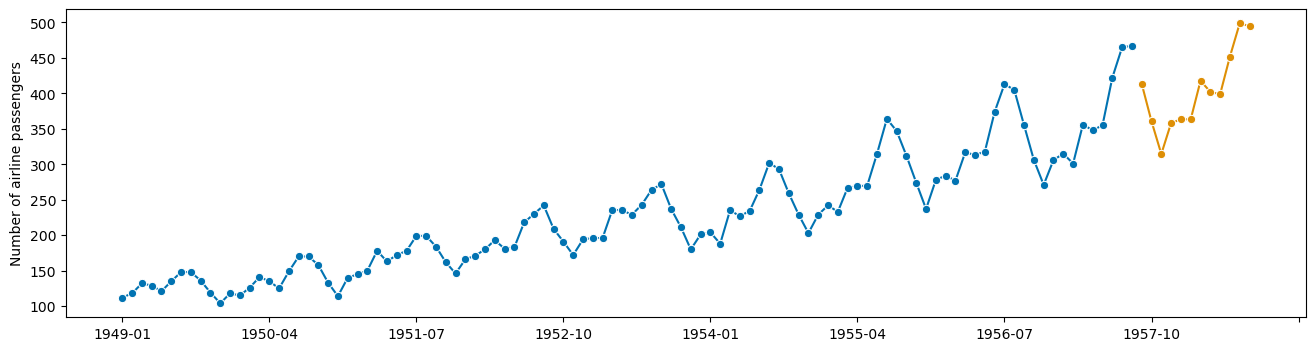

In [24]:
y_pred = forecaster.predict(fh)

plot_series(y_observed,y_pred)

### 7. Observe new data 

In [25]:
y_observed = y.loc[:'1957-09']
new_data = y.loc[['1957-09']]
new_data

1957-09    404.0
Freq: M, Name: Number of airline passengers, dtype: float64

### 8. Model update

In [26]:
forecaster.update(new_data)

d:\Miniconda\envs\sktime_env\lib\site-packages\sktime\forecasting\base\_base.py:1640: UserWarning: NotImplementedWarning: AutoETS does not have a custom `update` method implemented. AutoETS will be refit each time `update` is called with update_params=True.
  warn(


AutoETS(auto=True, n_jobs=-1, sp=12)

Notice the warning: this type of model does not have a specific `update` method, so it resorts to refitting the model from scratch

### 6. Model predict (after update)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

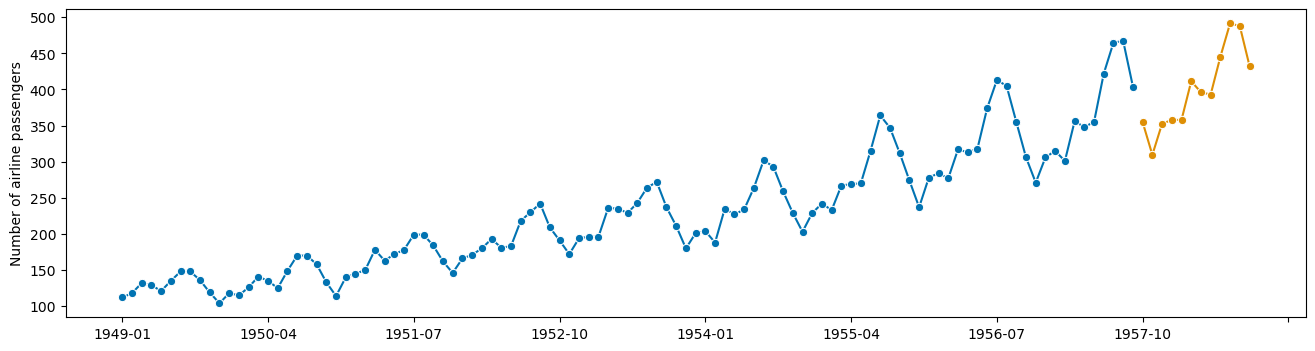

In [27]:
y_pred = forecaster.predict(fh)

plot_series(y_observed,y_pred)

#### Documentation on `update`

In [28]:
forecaster.update?

Signature: forecaster.update(y, X=None, update_params=True)
Docstring:
Update cutoff value and, optionally, fitted parameters.

If no estimator-specific update method has been implemented,
default fall-back is as follows:
    update_params=True: fitting to all observed data so far
    update_params=False: updates cutoff and remembers data only

State required:
    Requires state to be "fitted".

Accesses in self:
    Fitted model attributes ending in "_".
    Pointers to seen data, self._y and self.X
    self.cutoff, self._is_fitted
    If update_params=True, model attributes ending in "_".

Writes to self:
    Update self._y and self._X with `y` and `X`, by appending rows.
    Updates self. cutoff and self._cutoff to last index seen in `y`.
    If update_params=True,
        updates fitted model attributes ending in "_".

Parameters
----------
y : time series in sktime compatible data container format
        Time series to which to fit the forecaster in the update.
    y can be in on

If the parameter `update_params` of `update` is set to `False`, the model is not refitted, and just the cutoff is updated

## Automating the process
sktime helps to automate the workflow, using:
- `ExpandingWindowSplitter` to define the cross validation strategy
- `evaluate` to update-evaluate the model iteratively

### Example

In [29]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_airline()
fh = ForecastingHorizon(np.arange(12) + 1)
y_train, y_test = temporal_train_test_split(y, fh=fh)

#### Define the temporal cross-validation

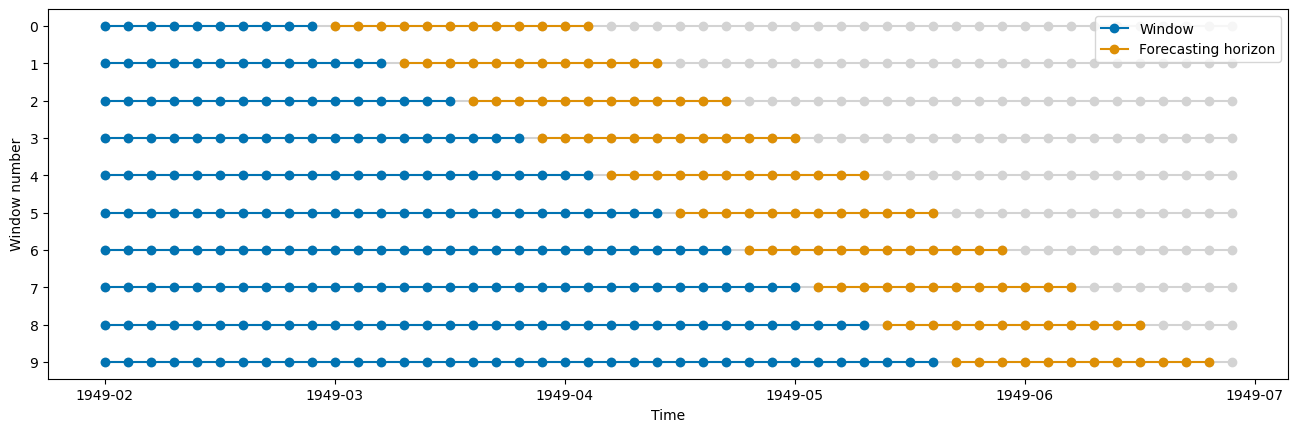

In [31]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from custom_utils.custom_function import plot_windows

cv = ExpandingWindowSplitter(step_length=3, fh=fh, initial_window=10)
plot_windows(cv, y.iloc[:50])

So, the `ExpandingWindowSplitter` class helps to create windows that expand, setting an initial window width (`initial_window`) and a step of expansion (`step_length`)

#### Backtesting: evaluation using temporal cross-validation

In [36]:
from sktime.forecasting.model_evaluation import evaluate

# Specify the model
forecaster = NaiveForecaster(strategy='last', sp=12)

# Define the cross validation windows
cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=72)

# Use evaluate to update-evaluate the model
results = evaluate(forecaster=forecaster, y=y, cv=cv, strategy='refit', return_data=True)
results.iloc[:, :5].head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.158429,0.011090,0.005681,72,1954-12
1,0.134854,0.009577,0.005354,84,1955-12
2,0.107586,0.013316,0.005163,96,1956-12
3,0.031351,0.010443,0.004838,108,1957-12
4,0.110579,0.012159,0.004914,120,1958-12


So, `evaluate` is a function that
- given a time series (`y`)
- given a forecaster
- given a cross-validation-windows object (`cv`)

internally performs the update-evaluation cycles.

Notice that the `len_train_window` increases by 12 at each cycle, since the `step_lenght` was set to 12 in the `cv` definition

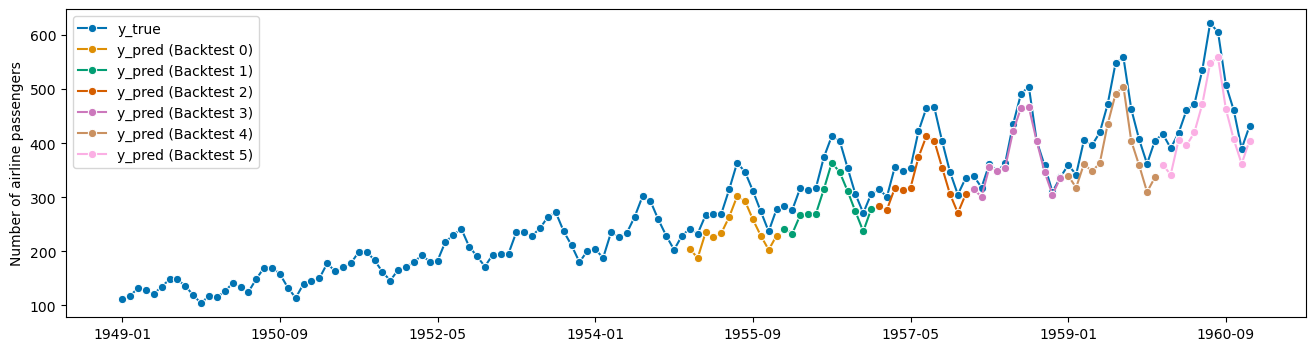

In [37]:
fig, ax = plot_series(
    y, 
    results['y_pred'].iloc[0],
    results['y_pred'].iloc[1],
    results['y_pred'].iloc[2],
    results['y_pred'].iloc[3],
    results['y_pred'].iloc[4],
    results['y_pred'].iloc[5],
    labels=['y_true'] + [f'y_pred (Backtest {str(x)})' for x in range(6)]
)

ax.legend()

## Advanced model building & composition

### Tuning
sktime allows to tune the hyperparameters of the model using [`ForecastingGridSearchCV`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.model_selection.ForecastingGridSearchCV.html)

#### Example 

1. Load the data

In [1]:
from sktime.datasets import load_airline

y = load_airline()

2. Specify the forecasting horizon

In [2]:
from sktime.forecasting.base import ForecastingHorizon
import numpy as np

fh = ForecastingHorizon(np.arange(12) + 1)

3. Split the data

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, fh=fh)

4. Define the model

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy='recursive')

5. Specify the parameter grid and the cross validation strategy to use

In [15]:
param_grid = {
    'window_length' : [9,12,15],
    'estimator__n_neighbors' : np.arange(1,10)
}

from sktime.forecasting.model_selection import SlidingWindowSplitter

cv = SlidingWindowSplitter(window_length=60, fh=fh)

> Notice the difference between `ExpandingWindowSplitter` and `SlidingWindowSplitter`:
> - `ExpandingWindowSplitter` always starts from the beginning of the time series
> - `SlidingWindowSplitter` considers a sliding window of fixed length

6. Define the grid search object

In [23]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV

gscv = ForecastingGridSearchCV(forecaster=forecaster, cv=cv, param_grid=param_grid, strategy='refit', n_jobs=-1)

#### 7. Train the model and let the grid search find the best parameter combination

In [24]:
gscv.fit(y_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', is_relative=True), window_length=30),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor()),
                        n_jobs=-1,
                        param_grid={'estimator__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                    'window_length': [9, 12, 15]})

8. Predict

In [25]:
y_pred = gscv.predict(fh)

d:\Miniconda\envs\sktime_env\lib\site-packages\sklearn\utils\metaestimators.py:201: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(


9. Evaluate

0.12999170630652618

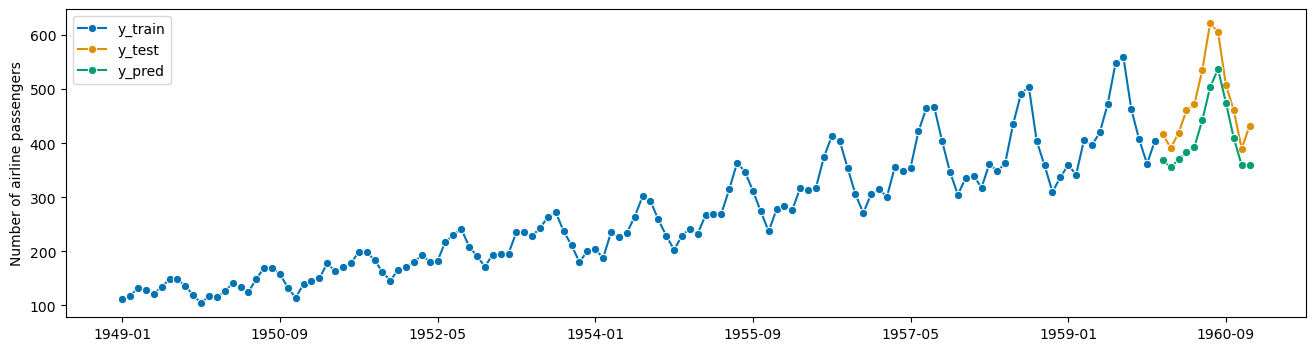

In [26]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [27]:
gscv.best_params_

{'estimator__n_neighbors': 3, 'window_length': 15}

Notice how `window_length` in the parameter grid and `window_length` in the `SlidingWindowSplitter` work

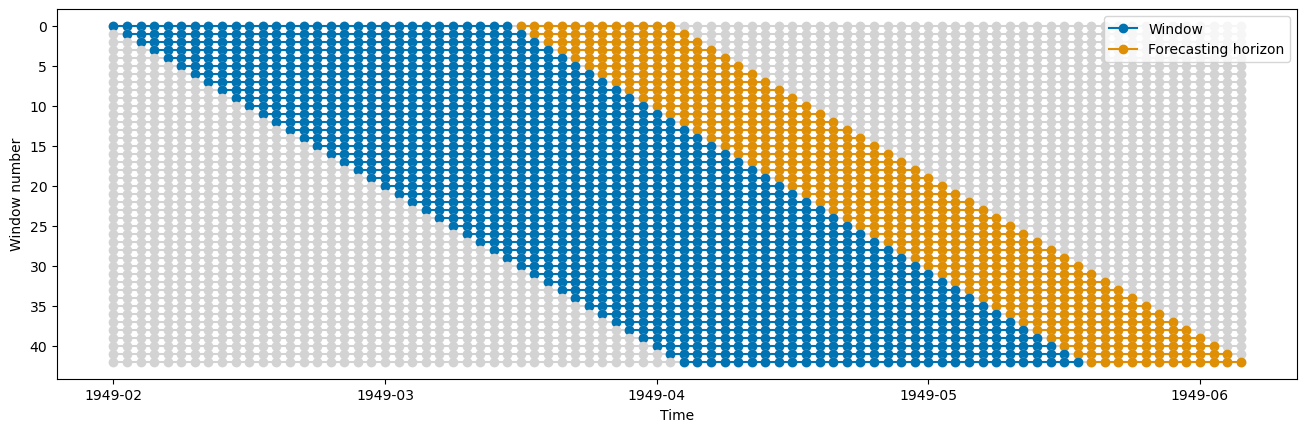

In [28]:
from custom_utils.custom_function import plot_windows

plot_windows(cv, y.iloc[:84])

- In the parameter grid the forecasting horizon is specified, so that the grid search considers different forecasting horizons
- In `SlidingWindowSplitter` a fixed value for the validation window width is set; so these windows are related to evaluation

### Tuning and AutoML
sktime allows to compare the performance of different models using `MultiplexForecaster`
#### Example

1. Load the data

In [1]:
from sktime.datasets import load_airline

y = load_airline()

2. Specify the forecasting horizon

In [2]:
from sktime.forecasting.base import ForecastingHorizon
import numpy as np

fh = ForecastingHorizon(np.arange(12) + 1)

3. Split the data

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, fh=fh)

4. Define the model

In [4]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = MultiplexForecaster(
    forecasters=[
        ('naive', NaiveForecaster(strategy='last')),
        ('ets', ExponentialSmoothing(trend='add',sp=12)),
    ]
)

Notice that `MultiplexForecaster` is quite similar to a pipeline: it allows to define a list of estimators to use consecutively during the grid search, that is going to keep the best-performing one.

5. Specify the parameter grid and the cross validation strategy to use

In [7]:
param_grid = {
    'selected_forecaster' : ['ets','naive']
}

from sktime.forecasting.model_selection import SlidingWindowSplitter

cv = SlidingWindowSplitter(window_length=60, fh=fh)

6. Define the grid search object

In [8]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV

gscv = ForecastingGridSearchCV(forecaster=forecaster, cv=cv, param_grid=param_grid, strategy='refit', n_jobs=-1)

7. Train the model and let the grid search find the best parameter combination

In [9]:
gscv.fit(y_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', is_relative=True), window_length=60),
                        forecaster=MultiplexForecaster(forecasters=[('naive',
                                                                     NaiveForecaster()),
                                                                    ('ets',
                                                                     ExponentialSmoothing(sp=12,
                                                                                          trend='add'))]),
                        n_jobs=-1,
                        param_grid={'selected_forecaster': ['ets', 'naive']})

8. Predict

In [10]:
y_pred = gscv.predict(fh)

d:\Miniconda\envs\sktime_env\lib\site-packages\sklearn\utils\metaestimators.py:201: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(


9. Evaluate

0.1258742688858975

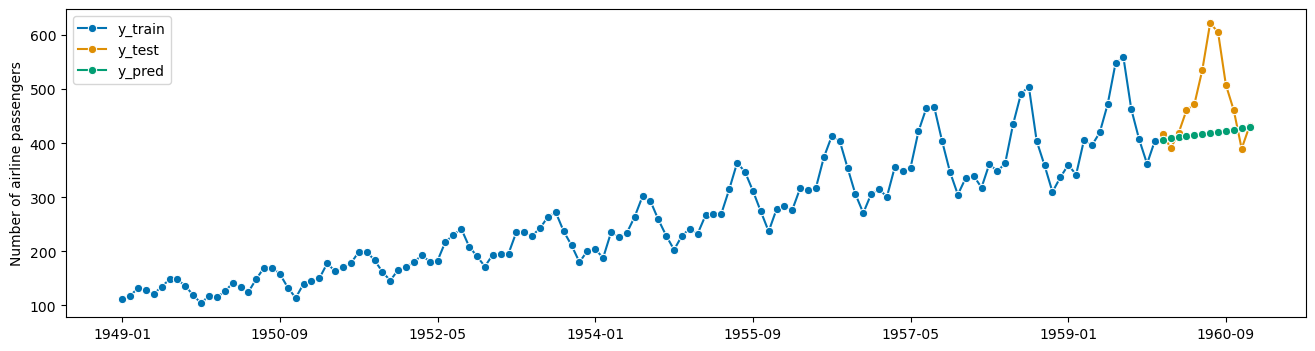

In [11]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [12]:
gscv.best_params_

{'selected_forecaster': 'ets'}

Notice how `window_length` in the parameter grid and `window_length` in the `SlidingWindowSplitter` work

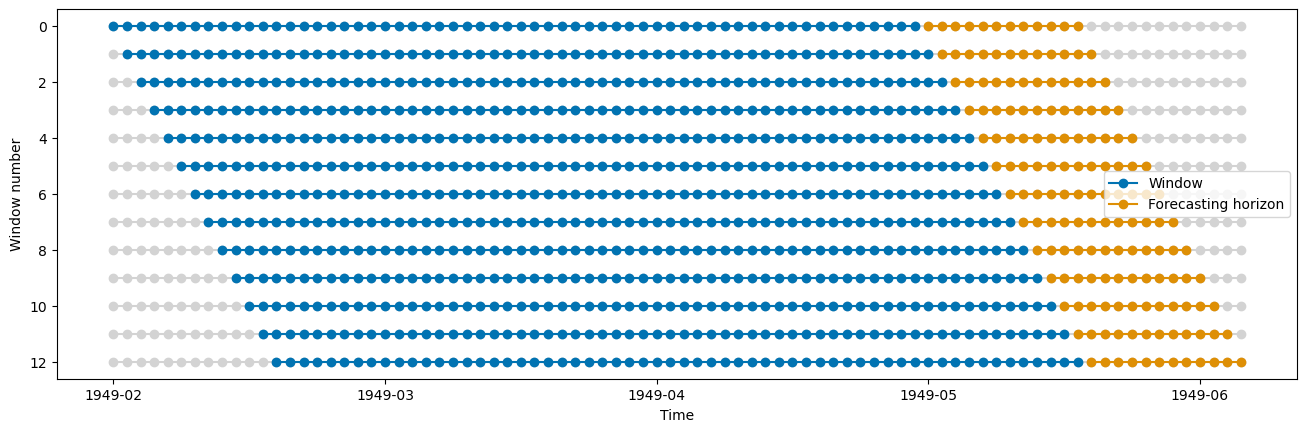

In [13]:
from custom_utils.custom_function import plot_windows

plot_windows(cv, y.iloc[:84])

### Pipeline
sktime allows to create pipelines, to concatenate transformations and model in a simple way, helping to avoid data leakage
#### Example

1. Load the data

In [1]:
from sktime.datasets import load_airline

y = load_airline()

2. Specify the forecasting horizon

In [2]:
from sktime.forecasting.base import ForecastingHorizon
import numpy as np

fh = ForecastingHorizon(np.arange(12) + 1)

3. Split the data

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, fh=fh)

4. Define the model

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy='recursive')

5. Specify the pipeline

In [5]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

forecaster_pipeline = TransformedTargetForecaster(
    [
        ('deseasonalize', Deseasonalizer(sp=12)),
        ('detrend', Detrender()),
        ('forecast', forecaster)
    ]
)

- The [`Deseasonalizer`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.series.detrend.Deseasonalizer.html) removes seasonal components from a time series
- The [`Detrender`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.series.detrend.Detrender.html) removes a trend from a time series

6. Fit

In [6]:
forecaster_pipeline.fit(y_train)

TransformedTargetForecaster(steps=[('deseasonalize', Deseasonalizer(sp=12)),
                                   ('detrend', Detrender()),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor()))])

7. Predict 

In [7]:
y_pred = forecaster_pipeline.predict(fh)

8. Evaluate

0.0596278852577471

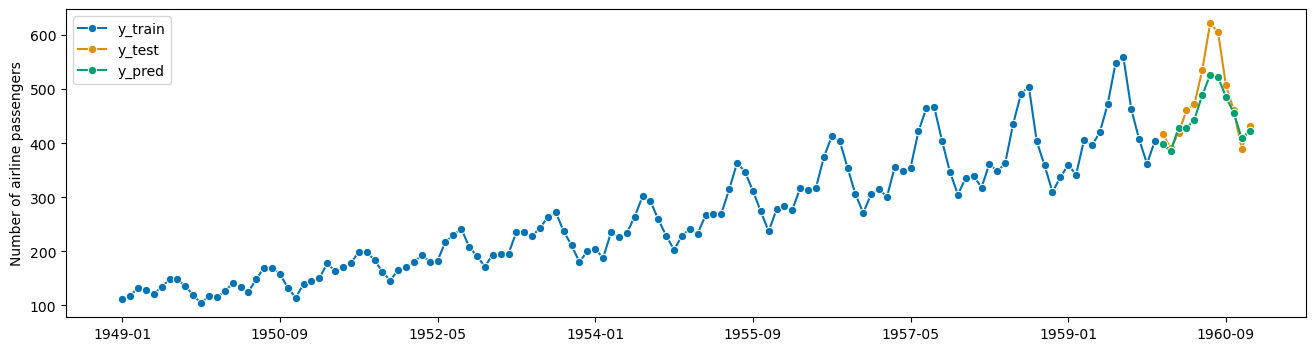

In [8]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

## Univariate forecasting with exogenous variables
- a single target (or endogenous) series, observed only in the past
- one or more related (exogenous) time series, observed in the past and period of forecasting horizon

In other words: the goal is to forecast on an endogenous series (`y`), but also other exogenous series are available (`X`), and these series are observed not only for past periods, but also for future periods (e.g., a shipping order, an appointment on the calendar), or may be variables easy to predict.

### Basic workflow

1. Load the data

In [37]:
from sktime.datasets import load_longley

y, X = load_longley()

In [13]:
type(y), type(X)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

`y` is the endogenous data

In [14]:
y.head()

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

`X` is the exogenous data

In [15]:
X.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


2. Specify the forecasting horizon

In [38]:
import numpy as np

fh = np.arange(5) + 1

3. Split the data

In [39]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=fh)

The second split of the exogenous data `X` is called `X_pred`, and that is quite different from the normal workflow using scikit-learn, where this split is usually called `X_test`. That's to remark upon their theoretical difference 
- `X_pred` values are considered observed and known, and are used in the predict step
- `X_test` values are considered unknown, and are used only to evaluate the model

4. Define the model

In [40]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(suppress_warnings=True)

5. Fit the model

In [41]:
forecaster.fit(y_train, X_train)

AutoARIMA(suppress_warnings=True)

Notice that the training split of the exogenous data (`X_train`) is passed to the `fit` method as an additional parameter

6. Predict

In [42]:
y_pred = forecaster.predict(fh=fh, X=X_pred)

Notice that the prediction split of the exogenous data (`X_pred`) is passed to the `predict` method as an additional parameter

7. Evaluate

0.030152354590032522

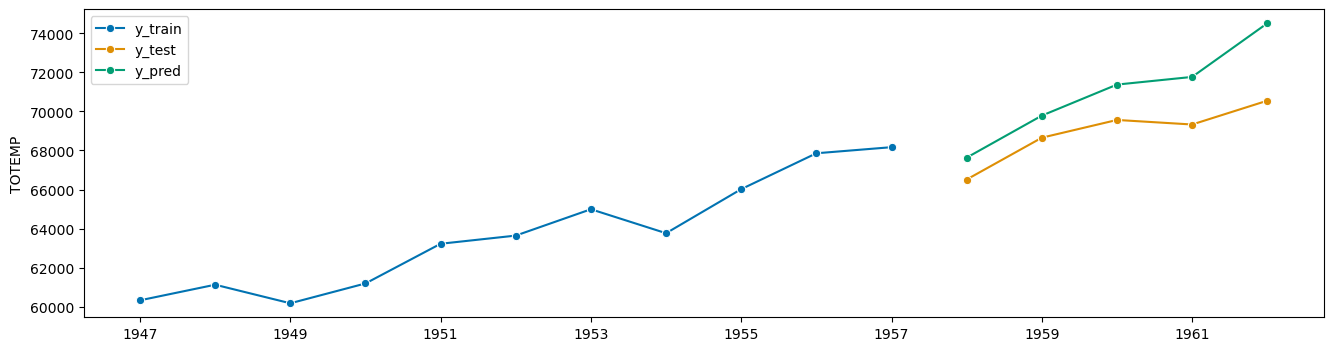

In [43]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### Pipelining with exogenous data
It is also possible to consider exogenous data using pipelines

#### Example

1. Load the data

In [1]:
from sktime.datasets import load_macroeconomic

data = load_macroeconomic()
y = data['unemp']
X = data.drop(columns=['unemp'])

In [2]:
(type(y), type(X))

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [3]:
y.head()

Period
1959Q1    5.8
1959Q2    5.1
1959Q3    5.3
1959Q4    5.6
1960Q1    5.2
Freq: Q-DEC, Name: unemp, dtype: float64

In [4]:
X.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,pop,infl,realint
Period,,,,,,,,,,,
1959Q1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,177.146,0.00,0.00
1959Q2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,177.830,2.34,0.74
1959Q3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,178.657,2.74,1.09
1959Q4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,179.386,0.27,4.06
1960Q1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,180.007,2.31,1.19


2. Split the data

In [2]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X)

3. Specify the forecasting horizon

In [3]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)

4. Define the model

In [4]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(suppress_warnings=True)

5. Specify the pipeline

In [6]:
from sktime.forecasting.compose import ForecastingPipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.impute import Imputer

forecaster_pipeline = ForecastingPipeline(
    [
        ('imputer', Imputer(method='mean')),
        ('scale', TabularToSeriesAdaptor(MinMaxScaler(feature_range=(1,2)))),
        ('boxcox', TabularToSeriesAdaptor(PowerTransformer(method='box-cox'))),
        ('forecaster', forecaster)
    ]
)

Notice that now the class used to create the pipeline is `ForecastingPipeline`, and not `TransformedTargetForecaster` as in a previous example:
- [`TransformedTargetForecaster`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.compose.TransformedTargetForecaster.html) is used to apply transformers on the target series (i.e., `y`)
- [`ForecastingPipeline`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.compose.ForecastingPipeline.html) is used to apply transformers to the exogenous data (i.e., `X`); the `forecaster` parameter may be a `TransformedTargetForecaster` object, so that transforms are applied on both exogenous and endogenous data in the same pipeline

The [`TabularToSeriesAdaptor`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.series.adapt.TabularToSeriesAdaptor.html) class is a class that allows to transform any sklearn transformer in a sktime transformer.

[`Imputer`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.transformations.series.impute.Imputer.html?highlight=imputer) is a class to impute missing values

6. Fit the model

In [7]:
forecaster.fit(y_train, X_train)

d:\Miniconda\envs\sktime_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\Miniconda\envs\sktime_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


AutoARIMA(suppress_warnings=True)

7. Predict

In [8]:
y_pred = forecaster.predict(fh=fh, X=X_pred)

8. Evaluate

0.15686966235472122

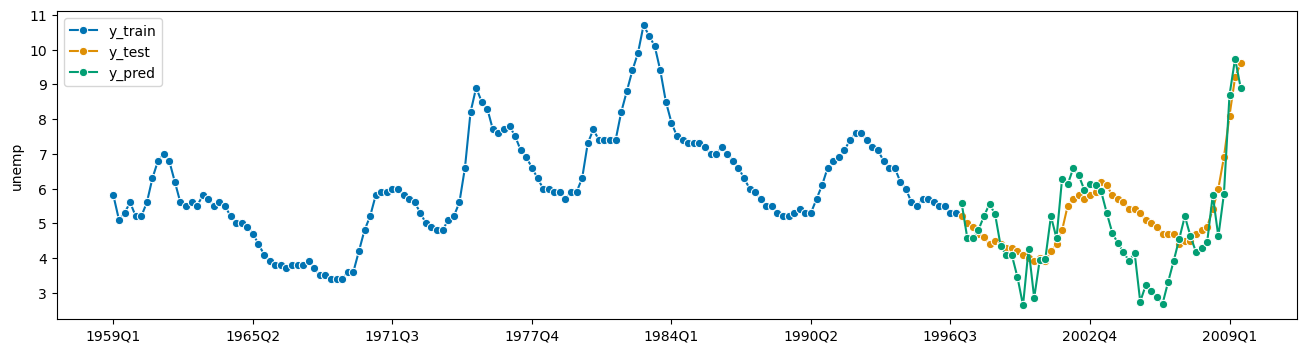

In [9]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

plot_series(y_train, y_test, y_pred, labels=['y_train','y_test','y_pred'])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

## Multivariate forecasting
In multivariate forecasting the goal is to perform predictions on multiple time series.

The following are the sktime estimators that can address multivariate forecasting problems

In [12]:
from sktime.registry import all_estimators

all_estimators(
    'forecaster',
    filter_tags={'scitype:y': ['both','multivariate']},
    return_names=False
)

[sktime.forecasting.compose._column_ensemble.ColumnEnsembleForecaster,
 sktime.forecasting.model_selection._tune.ForecastingGridSearchCV,
 sktime.forecasting.compose._pipeline.ForecastingPipeline,
 sktime.forecasting.model_selection._tune.ForecastingRandomizedSearchCV,
 sktime.forecasting.compose._multiplexer.MultiplexForecaster,
 sktime.forecasting.naive.NaiveForecaster,
 sktime.forecasting.compose._pipeline.TransformedTargetForecaster,
 sktime.forecasting.var.VAR]

#### Example

1. Load the data

In [30]:
from sktime.datasets import load_longley

_, y = load_longley()
y = y.iloc[:,2:4]

2. Specify the forecasting horizon

In [31]:
import numpy as np

fh = np.arange(3) + 1

3. Split the data

In [32]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, fh=fh)

In [33]:
y_train.head()

,UNEMP,ARMED
Period,,
1947,2356.0,1590.0
1948,2325.0,1456.0
1949,3682.0,1616.0
1950,3351.0,1650.0
1951,2099.0,3099.0


Notice that `y_train` is composed of 2 time series, and the goal is to make predictions about both at the same time.

At this point, two approaches are possible:
- **By-variable** (or by-column) **ensembling**, that is performing predictions separately for the time series, maybe also specifying different models for each time series using [`ColumnEnsembleForecaster`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.compose.ColumnEnsembleForecaster.html)
- **Bespoke multivariate models**, that is performing predictions on multiple time series, but taking into account the mutual effects that time series have on each other

##### By-variable ensembling

4. Define the model

In [34]:
from sktime.forecasting.compose import ColumnEnsembleForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ColumnEnsembleForecaster(
    forecasters=[
        ('trend', PolynomialTrendForecaster(), 0),
        ('ses', ExponentialSmoothing(), 1)
    ]
)

5. Fit the model

In [35]:
forecaster.fit(y_train)

ColumnEnsembleForecaster(forecasters=[('trend', PolynomialTrendForecaster(), 0),
                                      ('ses', ExponentialSmoothing(), 1)])

6. Predict

In [36]:
y_pred = forecaster.predict(fh)
y_pred.head()

,0,1
1960,3688.653846,2552.429032
1961,3794.186813,2552.429032
1962,3899.719780,2552.429032


7. Evaluate

0.06982903450016706

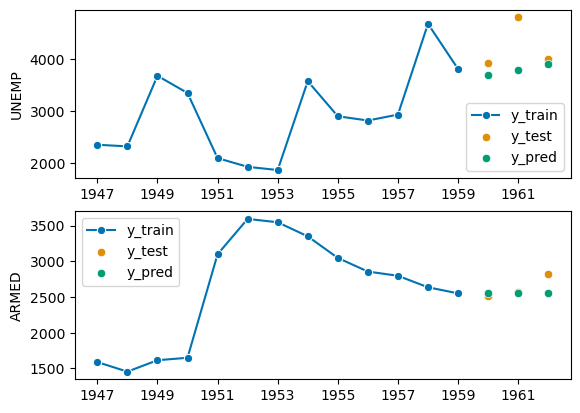

In [54]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1)

for col_id, _ in enumerate(y_train.columns):
    plot_series(y_train.iloc[:,col_id], y_test.iloc[:,col_id], y_pred.iloc[:,col_id], labels=['y_train','y_test','y_pred'], ax=ax[col_id])

mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

##### Bespoke multivariate models

4. Define the model

In [55]:
from sktime.forecasting.var import VAR

forecaster = VAR()

5. Fit the model

In [56]:
forecaster.fit(y_train)

VAR()

6. Predict

In [57]:
y_pred = forecaster.predict(fh)

7. Evaluate

0.14002104081395544

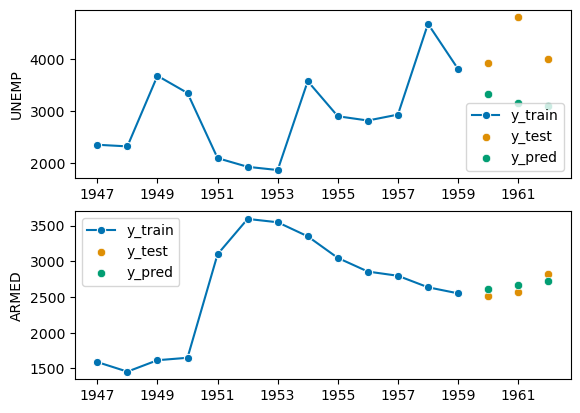

In [58]:
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1)

for col_id, _ in enumerate(y_train.columns):
    plot_series(y_train.iloc[:,col_id], y_test.iloc[:,col_id], y_pred.iloc[:,col_id], labels=['y_train','y_test','y_pred'], ax=ax[col_id])

mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

## Build custom forecasters
sktime allows to build custom forecasters using a template shared [here](https://github.com/alan-turing-institute/sktime/blob/main/extension_templates/forecasting.py)